# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants
import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Init

In [3]:
import datahandler


dataset_id = "oslo"

data_preprocessor = datahandler.DataPreprocessorOUS(dataset_id)
data_preprocessor.execute()

data_loader = datahandler.DataLoader(dataset_id)
data_loader.execute()


Loading dataset: 100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


# Plot

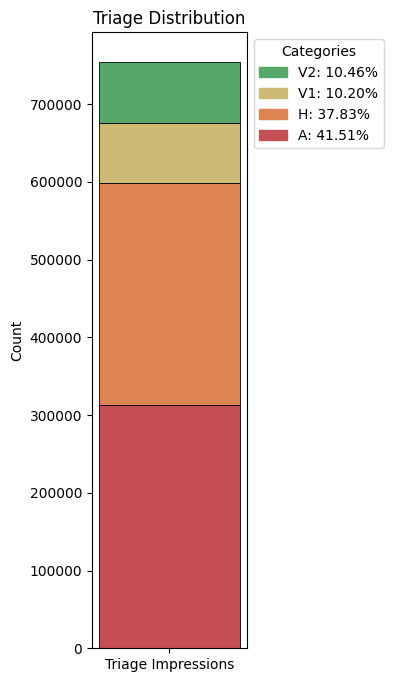

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


# Sample DataFrame, replace with your actual DataFrame
df = data_loader.processed_incidents_df

# Define categories and get counts
categories = ['A', 'H', 'V1', 'V2']
triage_counts = df['triage_impression_during_call'].value_counts()

# Get Seaborn's deep color palette
deep_palette = sns.color_palette("deep")

# Define custom color palette
custom_deep_palette = {
    'A': deep_palette[3],
    'H': deep_palette[1],
    'V1': deep_palette[8],
    'V2': deep_palette[2]
}

# Initialize variables
bottom = 0
total_count = sum([triage_counts.get(cat, 0) for cat in categories])
legend_labels = []
legend_colors = []

plt.figure(figsize=(2, 8))

# Create the stacked bar chart
for cat in categories:
    count = triage_counts.get(cat, 0)
    percentage = (count / total_count) * 100
    label = f"{cat}: {percentage:.2f}%"
    
    plt.bar('Triage Impressions', count, bottom=bottom, color=custom_deep_palette[cat], edgecolor='black', linewidth=0.6)
    bottom += count
    
    # Store labels and colors for legend
    legend_labels.append(label)
    legend_colors.append(custom_deep_palette[cat])

# Add labels and title
plt.yticks(range(0, bottom+1, 100000))  # Adjust the yticks as needed
plt.ylabel('Count')
plt.title('Triage Distribution')

# Add legend
# Reverse the labels and colors to have 'A' at the bottom and 'V2' at the top in the legend
plt.legend(handles=[plt.Rectangle((0,0),1,1, color=color) for color in reversed(legend_colors)], 
           labels=reversed(legend_labels), title='Categories', bbox_to_anchor=(1, 1), loc='upper left')

plt.show()


In [6]:
from datetime import datetime
import pandas as pd

# Initialize figure
plt.figure(figsize=(10, 6))

# Plot histogram for each category using the custom color palette
for cat in categories:
    sns.histplot(df[df['triage_impression_during_call'] == cat]['response_time'], 
                 kde=False, label=cat, color=custom_deep_palette[cat])

# Add labels and title
plt.xlabel('Response Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Times by Triage Category')
plt.legend(title='Categories')

# Show the plot
plt.show()

KeyError: 'response_time'

<Figure size 1000x600 with 0 Axes>

In [8]:
missing_time_arrival_scene = df['response_time'].isna().sum()



KeyError: 'response_time'